#**Wine Quality Analysis Exercise Solution**

We will now focus on our main objectives of building predictive models to predict the wine quality (low, medium and high) based on other features. We will be following the standard classification Machine Learning pipeline in this case. 

Adapted from Dipanjan Sarkar et al. 2018. [Practical Machine Learning with Python](https://link.springer.com/book/10.1007/978-1-4842-3207-1).

In [ ]:
# Import necessary dependencies
# We wil use matplotlib and seaborn for exploratory data analysis and visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

#Download Wine Quality Datasets

In [ ]:
!wget -O winequality-red.csv "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
!wget -O winequality-white.csv "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
!wget -O winequality.names "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality.names"

--2022-05-06 03:18:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [application/x-httpd-php]
Saving to: ‘winequality-red.csv’

winequality-red.csv 100%[===================>]  82.23K   271KB/s    in 0.3s    

2022-05-06 03:18:32 (271 KB/s) - ‘winequality-red.csv’ saved [84199/84199]

--2022-05-06 03:18:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264426 (258K) [application/x-httpd-php]
Saving to: ‘winequality-white.csv’

winequality-white.c 100%[======

# Load and merge datasets

In [ ]:
white_wine = pd.read_csv('winequality-white.csv', sep=';')
red_wine = pd.read_csv('winequality-red.csv', sep=';')

# store wine type as an attribute
red_wine['wine_type'] = 'red'   
white_wine['wine_type'] = 'white'
# bucket wine quality scores into qualitative quality labels
# Wine quality scores of 3, 4, and 5 are mapped to low quality,
# 6 and 7 are mapped to medium quality, 8 and 9 are mapped to high quality 
# wines under the quality_label attribute. 
red_wine['quality_label'] = red_wine['quality'].apply(lambda value: 'low' 
                                                          if value <= 5 else 'medium' 
                                                              if value <= 7 else 'high')
red_wine['quality_label'] = pd.Categorical(red_wine['quality_label'], 
                                           categories=['low', 'medium', 'high'])

white_wine['quality_label'] = white_wine['quality'].apply(lambda value: 'low' 
                                                              if value <= 5 else 'medium' 
                                                                  if value <= 7 else 'high')
white_wine['quality_label'] = pd.Categorical(white_wine['quality_label'], 
                                             categories=['low', 'medium', 'high'])

# merge red and white wine datasets
wines = pd.concat([red_wine, white_wine])
# re-shuffle records just to randomize data points
wines = wines.sample(frac=1, random_state=42).reset_index(drop=True)

# Understand dataset features and values

In [ ]:
print(white_wine.shape, red_wine.shape)
print(wines.info())

(4898, 14) (1599, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   fixed acidity         6497 non-null   float64 
 1   volatile acidity      6497 non-null   float64 
 2   citric acid           6497 non-null   float64 
 3   residual sugar        6497 non-null   float64 
 4   chlorides             6497 non-null   float64 
 5   free sulfur dioxide   6497 non-null   float64 
 6   total sulfur dioxide  6497 non-null   float64 
 7   density               6497 non-null   float64 
 8   pH                    6497 non-null   float64 
 9   sulphates             6497 non-null   float64 
 10  alcohol               6497 non-null   float64 
 11  quality               6497 non-null   int64   
 12  wine_type             6497 non-null   object  
 13  quality_label         6497 non-null   category
dtypes: category(1), float64(11), int64

We have 4898 white wine data points and 1599 red wine data points. The
merged dataset contains a total of 6497 data points and we also get an idea of numeric and categorical
attributes.

In [ ]:
# Let’s take a peek at our dataset to see some sample data points.
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_label
0,7.0,0.17,0.74,12.8,0.045,24.0,126.0,0.99420,3.26,0.38,12.2,8,white,high
1,7.7,0.64,0.21,2.2,0.077,32.0,133.0,0.99560,3.27,0.45,9.9,5,red,low
2,6.8,0.39,0.34,7.4,0.020,38.0,133.0,0.99212,3.18,0.44,12.0,7,white,medium
3,6.3,0.28,0.47,11.2,0.040,61.0,183.0,0.99592,3.12,0.51,9.5,6,white,medium
4,7.4,0.35,0.20,13.9,0.054,63.0,229.0,0.99888,3.11,0.50,8.9,6,white,medium


#Utilty functions for model evaluation

In [ ]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]
    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  codes=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                codes=level_labels)) 
    print(cm_frame) 

def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)

def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1]-1] 
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        
        fpr, tpr, _ = roc_curve(y_test, y_score)      
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)
        
    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(label, roc_auc[i]), 
                     linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_model_decision_surface(clf, train_features, train_labels,
                                plot_step=0.02, cmap=plt.cm.RdYlBu,
                                markers=None, alphas=None, colors=None):
    
    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = train_features[:, 0].min() - plot_step, train_features[:, 0].max() + plot_step
    y_min, y_max = train_features[:, 1].min() - plot_step, train_features[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf_est = clone(clf)
    clf_est.fit(train_features,train_labels)
    if hasattr(clf_est, 'predict_proba'):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)
    
    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = ''.join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == i)
        plt.scatter(train_features[idx, 0], train_features[idx, 1], c=color,
                    label=label_names[i], cmap=cmap, edgecolors='black', 
                    marker=markers[i], alpha=alphas[i])
    plt.legend()
    plt.show()


#Predicting Wine Quality

We will predict the wine quality ratings based on other features. To start with, we
will first select our necessary features and separate out the prediction class labels and prepare train and test
datasets. We use the prefix **wqp_** in our variables to easily identify them as needed, where **wqp** depicts wine
quality prediction.

In [ ]:
wqp_features = wines.iloc[:,:-3]
wqp_class_labels = np.array(wines['quality_label'])
wqp_label_names = ['low', 'medium', 'high']
wqp_feature_names = list(wqp_features.columns)
wqp_train_X, wqp_test_X, wqp_train_y, wqp_test_y = train_test_split(wqp_features, wqp_class_labels, 
                                                                    test_size=0.3, random_state=42)

print(Counter(wqp_train_y), Counter(wqp_test_y))
print('Features:', wqp_feature_names)

Counter({'medium': 2737, 'low': 1666, 'high': 144}) Counter({'medium': 1178, 'low': 718, 'high': 54})
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


The numbers show us the wine samples for each class and we can also see the feature names which will
be used in our feature set.

##Feature Scaling

We will be using a standard scaler in this
scenario.

In [ ]:
# Define the scaler 
wqp_ss = StandardScaler().fit(wqp_train_X)

# Scale the train set
wqp_train_SX = wqp_ss.transform(wqp_train_X)

# Scale the test set
wqp_test_SX = wqp_ss.transform(wqp_test_X)

##Train, Predict & Evaluate Model using Decision Tree
The main advantage of decision tree based models is model
interpretability, since it is quite easy to understand and interpret the decision rules which led to a specific
model prediction. Besides this, other advantages include the model’s ability to handle both categorical
and numeric data with ease as well as multi-class classification problems. Trees can be even visualized to
understand and interpret decision rules better.

###Train the model using DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

wqp_dt = DecisionTreeClassifier()
wqp_dt.fit(wqp_train_SX, wqp_train_y)



DecisionTreeClassifier()

###Evaluate model performance

In [ ]:
# let’s predict the wine types for our test data samples and evaluate the performance.
wqp_dt_predictions = wqp_dt.predict(wqp_test_SX)

display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_dt_predictions, 
                                      classes=wqp_label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.7272
Precision: 0.7271
Recall: 0.7272
F1 Score: 0.7271

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         low       0.68      0.67      0.68       718
      medium       0.78      0.78      0.78      1178
        high       0.29      0.30      0.29        54

    accuracy                           0.73      1950
   macro avg       0.58      0.58      0.58      1950
weighted avg       0.73      0.73      0.73      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           481    231    6
        medium        223    921   34
        high            2     36   16


We get an overall F1 Score and model accuracy of approximately 73%. 

Looking at the class based statistics; we can see the recall for the high quality
wine samples is pretty bad since a lot of them have been misclassified into medium and low quality ratings.
This is kind of expected since we do not have a lot of training samples for high quality wine if you remember
our training sample sizes from earlier. Considering low and high quality rated wine samples, we should at
least try to see if we can prevent our model from predicting a low quality wine as high and similarly prevent
predicting a high quality wine as low.

###Model Interpretation

####Visualize Feature Importances from Decision Tree Model

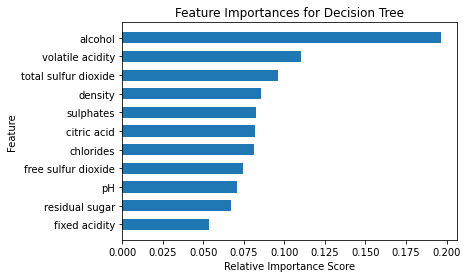

In [ ]:
wqp_dt_feature_importances = wqp_dt.feature_importances_
wqp_dt_feature_names, wqp_dt_feature_scores = zip(*sorted(zip(wqp_feature_names, wqp_dt_feature_importances), 
                                                          key=lambda x: x[1]))
y_position = list(range(len(wqp_dt_feature_names)))
plt.barh(y_position, wqp_dt_feature_scores, height=0.6, align='center')
plt.yticks(y_position , wqp_dt_feature_names)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Decision Tree')

We can clearly observe that the most important features have changed as compared to
our previous model. *Alcohol* and *volatile acidity* occupy the top two ranks and *total sulfur dioxide*
seems to be one of the most important features for classifying both wine type and quality.

####Visualize the Decision Tree

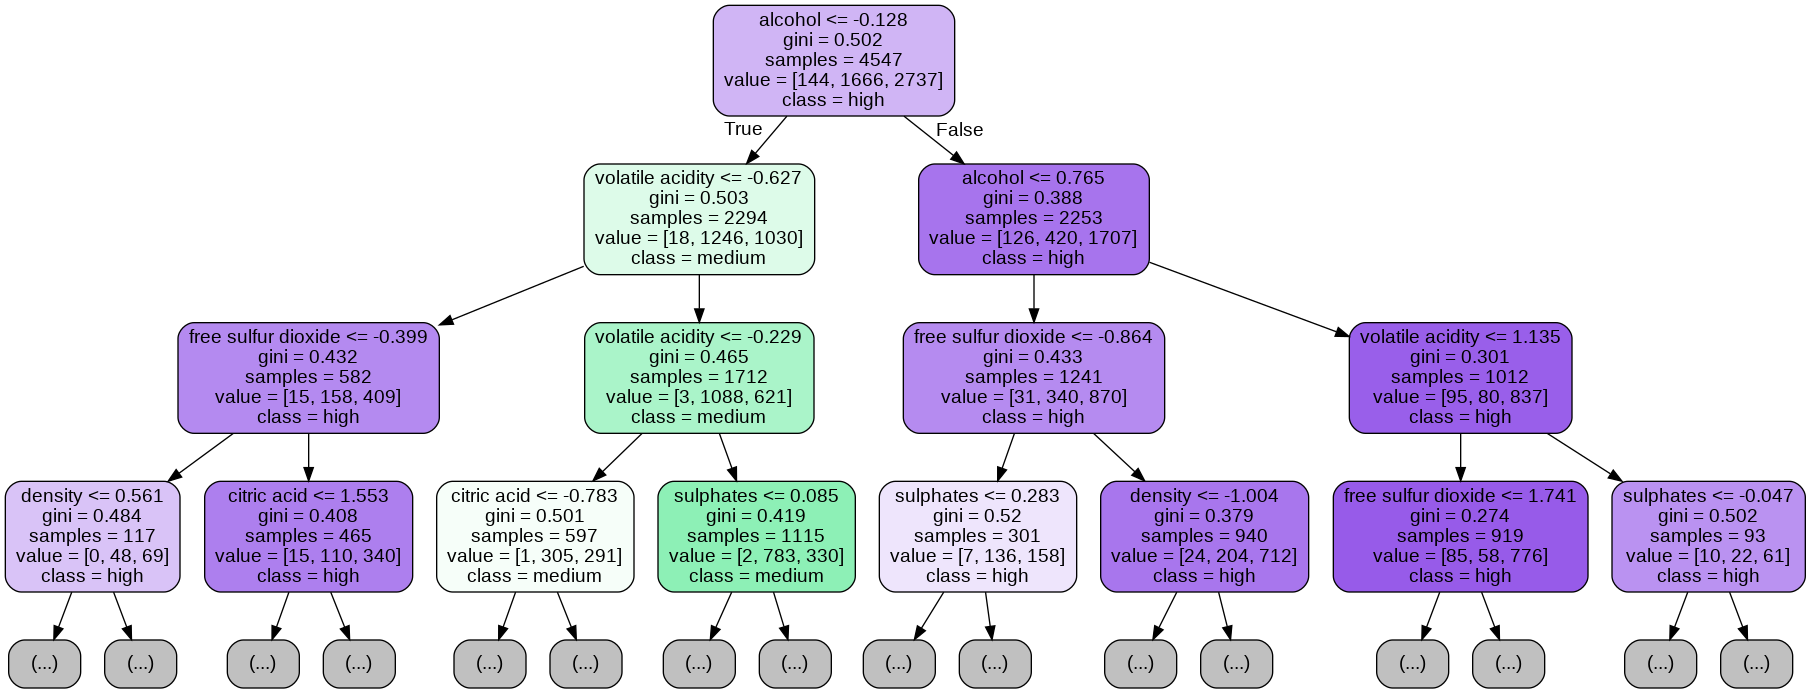

In [ ]:
from graphviz import Source
from sklearn import tree
from IPython.display import Image

graph = Source(tree.export_graphviz(wqp_dt, out_file=None, class_names=wqp_label_names,
                                    filled=True, rounded=True, special_characters=False,
                                    feature_names=wqp_feature_names, max_depth=3))
png_data = graph.pipe(format='png')
with open('dtree_structure.png','wb') as f:
    f.write(png_data)

Image(png_data)

Our decision tree model has a huge number of nodes and branches hence we visualized our tree for a
max depth of three.

You can start observing the decision rules from the tree
in the figure where the starting split is determined by the rule of alcohol <= -0.128 and with each
yes\no decision branch split, we have further decision nodes as we descend into the tree at each depth level.
The class variable is what we are trying to predict, i.e. wine quality being low, medium, or high and value
determines the total number of samples at each class present in the current decision node at each instance.

The gini parameter is basically the criterion which is used to determine and measure the quality of the split
at each decision node. Best splits can be determined by metrics like gini impurity\gini index or information
gain, a metric that helps in minimizing the probability of
misclassification. 

##Train, Predict & Evaluate Model using Random Forests

In the random
forest model, each base learner is a decision tree model trained on a bootstrap sample of the training data.
Besides this, when we want to split a decision node in the tree, the split is chosen from a random subset of all
the features instead of taking the best split from all the features.

####Train the model using RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# train the model
wqp_rf = RandomForestClassifier()
wqp_rf.fit(wqp_train_SX, wqp_train_y)

RandomForestClassifier()

####Evaluate model performance

In [ ]:
# predict and evaluate performance
wqp_rf_predictions = wqp_rf.predict(wqp_test_SX)
display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_rf_predictions, 
                                      classes=wqp_label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.7979
Precision: 0.7983
Recall: 0.7979
F1 Score: 0.7925

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         low       0.77      0.71      0.74       718
      medium       0.81      0.87      0.84      1178
        high       0.88      0.28      0.42        54

    accuracy                           0.80      1950
   macro avg       0.82      0.62      0.67      1950
weighted avg       0.80      0.80      0.79      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           511    206    1
        medium        147   1030    1
        high            2     37   15


The model prediction results on the test dataset depict an overall F1 Score and model accuracy of
approximately 80%. This is definitely an improvement of 7% from what we obtained
with just decision trees proving that ensemble learning is working better.

##Hyperparameter tuning with Grid Search & Cross Validation

Another way to further improve on this result is model tuning. To be more specific, models have
hyperparameters that can be tuned.

Hyperparameters are also known as meta-parameters
and are usually set before we start the model training process. These hyperparameters do not have any
dependency on being derived from the underlying data on which the model is trained. Usually these
hyperparameters represent some high level concepts or knobs, which can be used to tweak and tune the
model during training to improve its performance. Our random forest model has several hyperparameters as shown below.

In [ ]:
print(wqp_rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


###Get the best hyperparameter values using Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
                'n_estimators': [100, 200, 300, 500], 
                'max_features': ['auto', None, 'log2']    
              }

wqp_clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5,
                       scoring='accuracy')
wqp_clf.fit(wqp_train_SX, wqp_train_y)
print(wqp_clf.best_params_)

{'max_features': 'auto', 'n_estimators': 500}


We have 500 estimators and auto maximum features which represents the square root of the total
number of features to be considered during the best split operations.

###View grid search results

In [ ]:
results = wqp_clf.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean, 4), round(score_sd, 4))

{'max_features': 'auto', 'n_estimators': 100} 0.7898 0.0088
{'max_features': 'auto', 'n_estimators': 200} 0.7865 0.0085
{'max_features': 'auto', 'n_estimators': 300} 0.7876 0.0085
{'max_features': 'auto', 'n_estimators': 500} 0.7906 0.0083
{'max_features': None, 'n_estimators': 100} 0.7876 0.0122
{'max_features': None, 'n_estimators': 200} 0.7882 0.0096
{'max_features': None, 'n_estimators': 300} 0.7867 0.0101
{'max_features': None, 'n_estimators': 500} 0.7854 0.0107
{'max_features': 'log2', 'n_estimators': 100} 0.7898 0.0088
{'max_features': 'log2', 'n_estimators': 200} 0.7865 0.0085
{'max_features': 'log2', 'n_estimators': 300} 0.7876 0.0085
{'max_features': 'log2', 'n_estimators': 500} 0.7906 0.0083


The output shows the selected hyperparameter combinations and its corresponding mean
accuracy and standard deviation values across the grid.

##Train, Predict & Evaluate Random Forest Model with tuned hyperparameters

In [ ]:
wqp_rf = RandomForestClassifier(n_estimators=500, max_features='auto', random_state=42)
wqp_rf.fit(wqp_train_SX, wqp_train_y)

wqp_rf_predictions = wqp_rf.predict(wqp_test_SX)
display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_rf_predictions, 
                                      classes=wqp_label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.8077
Precision: 0.8095
Recall: 0.8077
F1 Score: 0.8019

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         low       0.80      0.72      0.75       718
      medium       0.81      0.89      0.85      1178
        high       0.94      0.28      0.43        54

    accuracy                           0.81      1950
   macro avg       0.85      0.63      0.68      1950
weighted avg       0.81      0.81      0.80      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           514    204    0
        medium        131   1046    1
        high            1     38   15


The model prediction results on the test dataset improved the overall F1 Score and model accuracy a little bit from the initial random forest model.

##Train, Predict & Evaluate Model using Extreme Gradient Boosting

Another way of modeling ensemble based methods is boosting. A very popular method is XGBoost
which stands for Extreme Gradient Boosting. It is a variant of the Gradient Boosting Machines (GBM)
model. This model is extremely popular in the Data Science community owing to its superior performance
in several Data Science challenges and competitions especially on Kaggle.

###Load and set dependencies

In [ ]:
import os

mingw_path = r'C:\mingw-w64\mingw64\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb

###Train the model

In [ ]:
wqp_xgb_model = xgb.XGBClassifier(seed=42)
wqp_xgb_model.fit(wqp_train_SX, wqp_train_y)

XGBClassifier(objective='multi:softprob', seed=42)

###Predict and Evaluate Model

In [ ]:
wqp_xgb_predictions = wqp_xgb_model.predict(wqp_test_SX)
display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_xgb_predictions, 
                                      classes=wqp_label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.7446
Precision: 0.7443
Recall: 0.7446
F1 Score: 0.7344

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         low       0.71      0.64      0.67       718
      medium       0.76      0.84      0.80      1178
        high       0.83      0.09      0.17        54

    accuracy                           0.74      1950
   macro avg       0.77      0.52      0.55      1950
weighted avg       0.74      0.74      0.73      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           456    261    1
        medium        187    991    0
        high            1     48    5


###Get the best hyperparameter values

In [ ]:
param_grid = {
                'n_estimators': [100, 200, 300], 
                'max_depth': [5, 10, 15],
                'learning_rate': [0.3, 0.5]
              }

wqp_clf = GridSearchCV(xgb.XGBClassifier(tree_method='exact', seed=42), param_grid, 
                       cv=5, scoring='accuracy')
wqp_clf.fit(wqp_train_SX, wqp_train_y)
print(wqp_clf.best_params_)

{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100}


###View grid search results

In [ ]:
results = wqp_clf.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean, 4), round(score_sd, 4))

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100} 0.7752 0.013
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200} 0.7816 0.0087
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300} 0.7812 0.0074
{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100} 0.7845 0.0077
{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 200} 0.7779 0.0072
{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 300} 0.7792 0.0065
{'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 100} 0.7843 0.0116
{'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 200} 0.7821 0.0089
{'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 300} 0.7792 0.0095
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100} 0.7763 0.0068
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 200} 0.7761 0.0076
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 300} 0.7768 0.0106
{'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 100} 0.7774 0.0057
{'learning_rate': 0.5, 'max_dept

###Train, Predict & Evaluate Extreme Gradient Boosted Model with tuned hyperparameters

In [ ]:
wqp_xgb_model = xgb.XGBClassifier(seed=42, max_depth=10, learning_rate=0.3, n_estimators=100)
wqp_xgb_model.fit(wqp_train_SX, wqp_train_y)

wqp_xgb_predictions = wqp_xgb_model.predict(wqp_test_SX)
display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_xgb_predictions, 
                                      classes=wqp_label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.7887
Precision: 0.7891
Recall: 0.7887
F1 Score: 0.7841

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         low       0.75      0.71      0.73       718
      medium       0.81      0.86      0.83      1178
        high       0.89      0.30      0.44        54

    accuracy                           0.79      1950
   macro avg       0.82      0.62      0.67      1950
weighted avg       0.79      0.79      0.78      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           511    207    0
        medium        165   1011    2
        high            3     35   16


The model prediction results on the test dataset depict an overall F1 Score and model accuracy of
approximately 79%. Though random forests perform slightly better, it definitely
performs better than a basic model like a decision tree.

##Model Interpretation

###Comparative analysis of Model Feature importances

In [ ]:
# Install skater package
!pip install git+https://github.com/oracle/Skater.git

  Cloning https://github.com/oracle/Skater.git to /tmp/pip-req-build-ydvll_vk
  Running command git clone -q https://github.com/oracle/Skater.git /tmp/pip-req-build-ydvll_vk


2022-05-06 03:26:59,221 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[11/11] features ████████████████████ Time elapsed: 8 seconds

Text(0, 0.5, 'Feature')

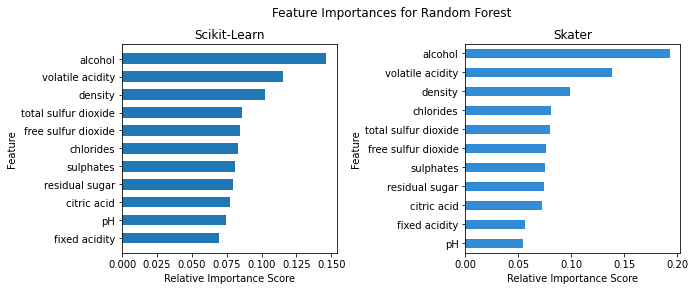

In [ ]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
# leveraging skater for feature importances
interpreter = Interpretation(wqp_test_SX, feature_names=wqp_feature_names)
wqp_im_model = InMemoryModel(wqp_rf.predict_proba, examples=wqp_train_SX, target_names=wqp_rf.classes_)
# retrieving feature importances from the scikit-learn estimator
wqp_rf_feature_importances = wqp_rf.feature_importances_
wqp_rf_feature_names, wqp_rf_feature_scores = zip(*sorted(zip(wqp_feature_names, wqp_rf_feature_importances), 
                                                          key=lambda x: x[1]))
# plot the feature importance plots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
t = f.suptitle('Feature Importances for Random Forest', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.6)
y_position = list(range(len(wqp_rf_feature_names)))
ax1.barh(y_position, wqp_rf_feature_scores, height=0.6, align='center', tick_label=wqp_rf_feature_names)
ax1.set_title("Scikit-Learn")
ax1.set_xlabel('Relative Importance Score')
ax1.set_ylabel('Feature')
plots = interpreter.feature_importance.plot_feature_importance(wqp_im_model, ascending=True, ax=ax2)
ax2.set_title("Skater")
ax2.set_xlabel('Relative Importance Score')
ax2.set_ylabel('Feature')

We can clearly observe from Figure that the most important features are consistent across the
two plots, which is expected considering we are just using different interfaces on the same model. The

###Visualize Model ROC Curve

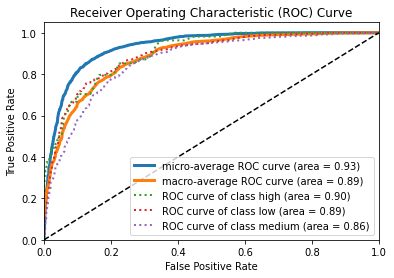

In [ ]:
plot_model_roc_curve(wqp_rf, wqp_test_SX, wqp_test_y)

The AUC is pretty good based on what we see. The dotted lines indicate the per-class ROC curves and
the lines in bold are the macro and micro-average ROC curves.

###Visualize Model decision surface

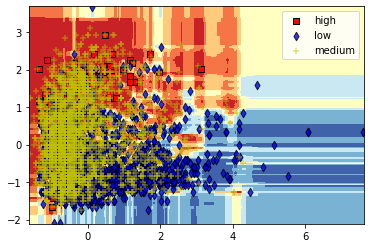

In [ ]:
feature_indices = [i for i, feature in enumerate(wqp_feature_names) 
                       if feature in ['alcohol', 'volatile acidity']]
plot_model_decision_surface(clf=wqp_rf, train_features=wqp_train_SX[:, feature_indices], 
                      train_labels=wqp_train_y, plot_step=0.02, cmap=plt.cm.RdYlBu,
                      markers=[',', 'd', '+'], alphas=[1.0, 0.8, 0.5], colors=['r', 'b', 'y'])

###Interpreting Model Predictions

In [ ]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(wqp_train_SX, feature_names=wqp_feature_names, 
                           discretize_continuous=True, 
                           class_names=wqp_rf.classes_)
# Model interpretation for our wine quality model's prediction for a low quality wine
exp.explain_instance(wqp_test_SX[10], wqp_rf.predict_proba, top_labels=1).show_in_notebook()

The figure above shows us the features that were primarily responsible for the model to
predict the wine quality as low. We can see that the most important feature was alcohol, which makes sense
considering what we obtained in our analyses so far from feature importances and model decision surface
interpretations. The values for each corresponding feature depicted here are the scaled values obtained after
feature scaling.

In [ ]:
# Model interpretation for our wine quality model's prediction for a high quality wine
exp.explain_instance(wqp_test_SX[747], wqp_rf.predict_proba, top_labels=1).show_in_notebook() 

We can see the features responsible for the model correctly
predicting the wine quality as high and the primary feature was again alcohol by volume (besides other
features like density, volatile acidity, and so on). Also you can notice a stark difference in the scaled
values of alcohol for the two instances

###Visualizing partial dependencies

In general, partial dependence helps describe the marginal impact
or influence of a feature on the model prediction decision by holding the other features constant. Because it
is very difficult to visualize high dimensional feature spaces, typically one or two influential and important
features are used to visualize partial dependence plots.

####one-way partial dependence

2022-05-06 03:27:25,170 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[81/81] grid cells ████████████████████ Time elapsed: 41 seconds

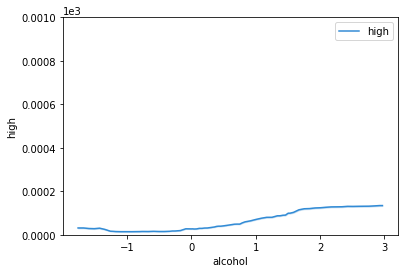

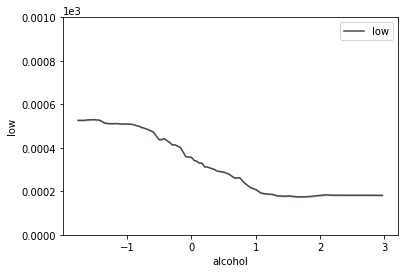

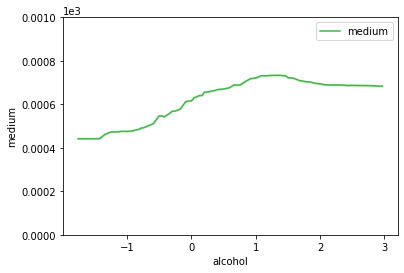

In [ ]:
# plot one-way partial dependence plots for our model prediction function 
# based on the most important feature, alcohol.
axes_list = interpreter.partial_dependence.plot_partial_dependence(['alcohol'], wqp_im_model, 
                                                                   grid_resolution=100, 
                                                                   with_variance=True,
                                                                   figsize = (6, 4))
axs = axes_list[0][3:]
[ax.set_ylim(0, 1) for ax in axs];

We can see that with an increase in the quantity of alcohol content, the
confidence\probability of the model predictor increases in predicting the wine to be either medium or high
and similarly it decreases for the probability of wine to be of low quality. This shows there is definitely some
relationship between the class predictions with the alcohol content and again the influence of alcohol for
predictions of class high is pretty low, which is expected considering training samples for high quality wine
are less.

####two-way partial dependence

2022-05-06 03:32:08,689 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[4050/4050] grid cells ████████████████████ Time elapsed: 3170 seconds

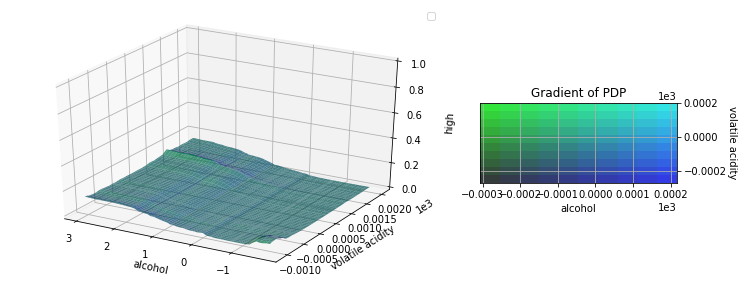

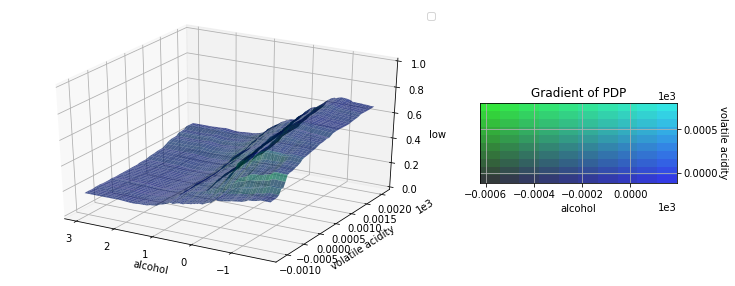

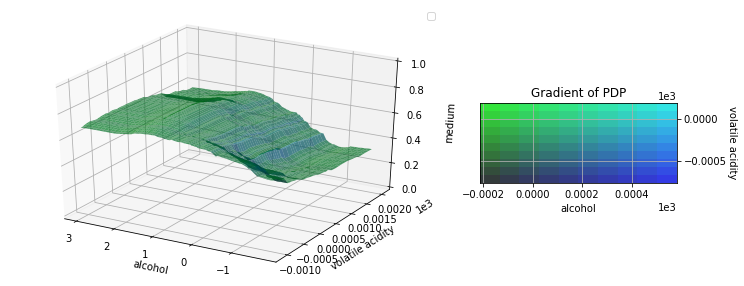

In [34]:
# plot wwo-way partial dependence plots for our random forest model predictor 
# based on alcohol and volatile acidity
plots_list = interpreter.partial_dependence.plot_partial_dependence([('alcohol', 'volatile acidity')], 
                                                                    wqp_im_model, n_samples=1000, figsize=(12, 5),
                                                                    grid_resolution=100)
axs = plots_list[0][3:]
[ax.set_zlim(0, 1) for ax in axs];

We can see predicting high
quality wine, due to the lack of training data, while some dependency is there for high wine quality class
prediction with the increase in alcohol and corresponding decrease in volatile acidity is it quite weak, as
we can see in the left most plot. There also seems to be a strong dependency on low wine quality class
prediction with the corresponding decrease in alcohol and the increase in volatile acidity levels. This
is clearly visible in the rightmost plot. The plot in the middle talks about medium wine quality class
predictions. We can observe predictions having a strong dependency with corresponding increase in alcohol
and with decrease in volatile acidity levels. This should give you a good foundation on leveraging partial
dependence plots to dive deeper into model interpretation.